*JSC270, Winter 2020 - Prof. Taback*

# <center>  Laboratory 7.1 - "Survival Analysis" </center>
## <center> Lab assignment </center>

### <center> Due date: March 9, 12:00pm (noon) </center>
<center> This assignment is a group assignment.  
You may work with the teammate of your choice.</center>


***
<div style="background-color: #f7f7f7; padding:10px;">

<h3>  Objectives </h3>

<ul>
    <li> Understand and apply survival analysis </li>
    <li> Understand supervised versus unsupervised learning </li>
    <li> Gain experience applying hierarchical clustering </li>
    <li> Gain experience working with Cancer Genomic data </li>
</ul>

<h3> Instructions </h3>

<ul>
    <li> Make a copy of this notebook using the Github Classroom link: <a href="https://classroom.github.com/a/bXmxTz_M">https://classroom.github.com/a/bXmxTz_M</a>.</li>
    <li> Answer the questions in the cells that indicate where your answers should be placed. You may remove the initial comment in the code cell. </li>
    <li> Make sure that you explain your solutions when asked and comment your code for readability. </li>
    <li> Commit and push changes to the Github classroom repository that has been provided (more details below).</li>
    <li> Submit a pdf report to Quercus (more details below).</li>

</div>

***


Can you identify distinct groups (biological “subtypes”) of patients with pancreas cancer, using The Cancer Genome Atlas (TCGA) transcriptome sequencing data, that have different survival times?
### Specific Questions

**Question 1.** Use hierarchical clustering to find 2 and 3 subgroups. Try at least two different linkage methods. Do you get different subgroups by trying different linkage methods? Provide a brief explanation of your results.


In [272]:
import glob
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# get list of file names
genefilenames = glob.glob('gdc_download_20200125_191127.229504/**/*.gz', recursive = True)

In [273]:
clinical = pd.read_csv('clinical.tsv', sep = '\t')
gdc_sample = pd.read_csv('gdc_sample_sheet.2020-01-26.tsv', sep = '\t')

In [274]:
rows = []

for i in range(len(genefilenames)):
    path = genefilenames[i]
    curr = pd.read_csv(path, sep = '\t', names = ['gene', 'rna'], index_col='gene')
    # calculate log of rna expression level
    curr["logrna"] = curr["rna"].transform(lambda x: np.log(x+1))
    curr = curr.drop(columns=["rna"])
    # transpose dataframe
    curr = curr.T

    # get the last part of file name, without name of directories
    curr['File Name'] = os.path.split(path)[1]
    # join with gdc_sample to get Case ID
    curr = pd.merge(curr, gdc_sample, how='inner', on=['File Name'])
    # drop unnecessary columns
    curr = curr.drop(columns=['File ID', 'Data Category', 'Data Type', 'Sample Type', 'Project ID',
                             'File Name', 'Sample ID'])
    # rename column to join with clinical
    curr = curr.rename(columns={"Case ID": "submitter_id"})
    rows.append(curr)
    
# create a single dataframe    
result = pd.concat(rows, ignore_index=True, sort=False)  

In [275]:
# remove genes where all entries are 0
result = result.loc[:, (result != 0).any(axis=0)]

In [276]:
df = pd.merge(clinical.iloc[::2], result, on='submitter_id', how='inner')

In [277]:
# code used to cluster genes (run on Google Colab to speed up with GPU)
# transposed = result.T
# transposed = transposed[:-1]
# ard_clustering = AgglomerativeClustering(n_clusters = 3)
# ward_cluster = ward_clustering.fit_predict(transposed.to_numpy()) 
# transposed["ward_cluster"] = ward_cluster

In [278]:
# read gene data that has been clustered into three groups
gene_cluster = pd.read_csv('cluster.csv')

In [298]:
gene_cluster.head()

,gene,0,1,2,3,4,ward_cluster
0,ENSG00000242268.2,0.000000,0.094539,0.108356,0.035278,0.000000,1
1,ENSG00000270112.3,0.003005,0.000000,0.003171,0.099509,0.000000,1
2,ENSG00000167578.15,1.372614,2.194936,1.567249,2.403033,1.481279,2
3,ENSG00000078237.5,1.581397,1.235283,1.451264,0.574299,1.454527,2
4,ENSG00000146083.10,2.754122,2.765173,2.621537,2.831057,2.441234,0


In [279]:
group_1 = []
group_2 = []
group_3 = []

# create lists of gene names in each group
for index, row in gene_cluster.iterrows():
    if row['ward_cluster'] == 0:
        group_1.append(row['gene'])
    elif row['ward_cluster'] == 1:
        group_2.append(row['gene'])
    elif row['ward_cluster'] == 2:
        group_3.append(row['gene'])

In [280]:
np.random.seed(22)

In [281]:
# use PCA to reduce the dimension of gene data
scaler = StandardScaler()
# reduce dimension of data to 30
pca =PCA(n_components= 30)
all_genes = group_1+ group_2 + group_3
all_genes = scaler.fit_transform(df[all_genes].to_numpy())

In [282]:
# cluster using genes in group 1
g1 = pca.fit_transform(all_genes[:,:len(group_1)])
# cluster using genes in group 2
g2 = pca.fit_transform(all_genes[:,len(group_1):len(group_1)+len(group_2)])
# cluster using genes in group 3
g3 = pca.fit_transform(all_genes[:,len(group_1)+len(group_2):])

In [283]:
# use linkage method of 'ward'
# use g3 because it performs best when clustering patients
ward_clustering = AgglomerativeClustering(n_clusters = 2)
ward_cluster = ward_clustering.fit_predict(g3) 
df["ward_cluster"] = ward_cluster

In [284]:
# use linkage method of 'complete'
complete_clustering = AgglomerativeClustering(n_clusters = 2,linkage="complete")
complete_cluster = complete_clustering.fit_predict(g3) 
df["complete_cluster"] = complete_cluster

First, we cluster the genes into three groups. According to national human research institute：
>All human beings are 99.9 percent identical in their genetic makeup. Differences in the remaining 0.1 percent hold important clues about the causes of diseases

Therefore, we will only select the group of genes that best clusters the patients. We use log transform on RNA expression level. Even after removing the genes where expression level is 0 for all patients, there are still 55.399 genes left, and the dimension is too large to generate meaningful results. So we use standardization and PCA (Principal component analysis) to reduce the dimensionality.

We are using two different linkage methods, ward and complete, to find two subgroups.
The ward linkage minimizes the variance of the clusters being merged, and the complete linkage uses the maximum distances between all observations of the two sets. The results from those two methods are presented below. We can see different subgroups by using those two linkage methods.

In [285]:
df.groupby("complete_cluster")["case_id"].count()

complete_cluster
0    179
1      3
Name: case_id, dtype: int64

In [286]:
df.groupby("ward_cluster")["case_id"].count()

ward_cluster
0     73
1    109
Name: case_id, dtype: int64

We believe complete clustering is affected by the noise in the data. So, we will use ward clustering for the rest of our analysis.

We draw the hierarchical clustering dendrogram to present an overview of those groups.

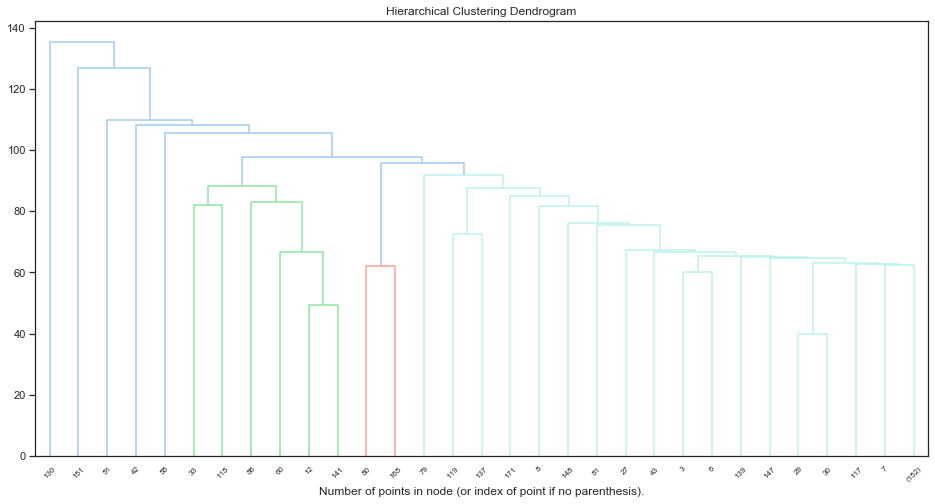

In [287]:
clustering = AgglomerativeClustering(distance_threshold=0,n_clusters = None,linkage="single")
model = clustering.fit(g3)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
plt.figure(figsize = (16,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [288]:
# only select useful columns to calculate survival time
clean_df = df[['days_to_last_follow_up', 'days_to_death', 'vital_status',"ward_cluster"]]

In [289]:
# choose survival time according to the status of the patient
clean_df['days_to_death'] = (np.where(clean_df['days_to_death'] == '--',
                                      np.NaN,clean_df['days_to_death']).astype(float))

clean_df['days_to_last_follow_up'] = np.where(clean_df['days_to_last_follow_up'] == '--',
                                              np.NaN,clean_df['days_to_last_follow_up']).astype(float)
clean_df["os"]= clean_df.apply(
    lambda x: x["days_to_death"] if (x["vital_status"] == "Dead") else x["days_to_last_follow_up"],axis=1)
clean_df['dead'] = np.where(clean_df.vital_status == 'Alive', 0, 
                            np.where(clean_df.vital_status == 'Dead', 1, None))

In [290]:
clean_df = clean_df.dropna(subset=["os"])

After some data wrangling and cleaning, we get the desired data frame:

`vital_status`: The survival state of the person registered on the protocol.

`days_to_last_follow_up`: The number of days between the date used for index and to the date the patient was lost to follow-up.

`days_to_death`: Number of days between the date used for index and the date from a person's date of death represented as a calculated number of days.

`ward_cluster`: The group that this patient belongs to.  

`os`: Survival time

`dead`: Whether the patient is dead.

In [291]:
clean_df.head()

,days_to_last_follow_up,days_to_death,vital_status,ward_cluster,os,dead
0,NaN,12.0,Dead,1,12.0,1
1,706.0,NaN,Alive,1,706.0,0
2,NaN,239.0,Dead,1,239.0,1
3,1794.0,NaN,Alive,1,1794.0,0
4,NaN,153.0,Dead,1,153.0,1


**Question 2.** What are the median survival times of the groups you found in part (a)? Provide a brief interpretation of the median survival times. Are the median survival times significantly different? Provide a brief interpretation of your results.

First, we can draw a side by side box plot for the survival time to compare their median survival time:

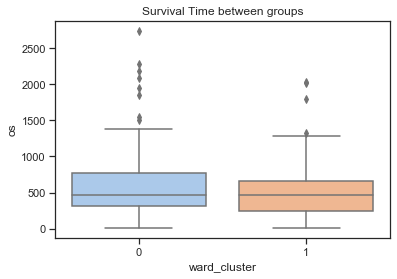

In [292]:
sns.set(style="ticks", palette="pastel")
g = sns.boxplot(y="os", x="ward_cluster",data = clean_df)
g.set_title("Survival Time between groups");

In [293]:
clean_df.groupby("ward_cluster")["os"].median()

ward_cluster
0    463.0
1    461.0
Name: os, dtype: float64

We can see the medians of the two groups are similar. However, the survival time for group 0, in general, is higher than group 1, as the first, second, and third quantiles for group 0 are all higher than group 1.

However, from the graph, we can not tell that there is a significant different in the the median survival times.

**Question 3.** Is there is a statistical difference in survival between the subgroups you found in (a)? Explain your reasoning.

First, let's show the Kaplan-Meier Curves between those two group.

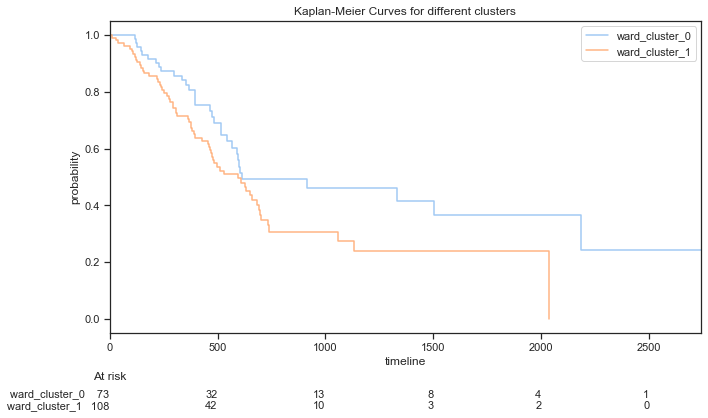

In [294]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

ward_cluster_0 = (clean_df['ward_cluster'] == 0)
ward_cluster_1 = (clean_df['ward_cluster'] == 1)
plt.figure(figsize=(10, 6))
f1 = KaplanMeierFitter()
f1.fit(clean_df['os'][ward_cluster_0], event_observed=clean_df['dead'][ward_cluster_0], label = 'ward_cluster_0')  
ax = f1.plot(ci_show=False)

f2 = KaplanMeierFitter()
f2.fit(clean_df['os'][ward_cluster_1], event_observed=clean_df['dead'][ward_cluster_1], label = 'ward_cluster_1')  
ax = f2.plot(ax=ax, ci_show=False)


ax.set_title("Kaplan-Meier Curves for different clusters")
ax.set_ylabel("probability")
add_at_risk_counts(f1, f2);

We can clearly see from the graph, the probability of estimated survival of cluster 0 is higher than cluster 1. Which indicates cluster 0 has higher probability of survival than cluster 1 in general.

We can use the logrank_test to test whether there is a statistical significance for KM survival curves between cluster 0 and cluster 1.


The null hypothesis $H_0:$ The two KM curves are equivalent.

Alternative hypothesis $H_A:$The two KM curves are different.

In [295]:
from lifelines.statistics import logrank_test
T1 = clean_df[clean_df['ward_cluster']==0]['os']
E1 = clean_df[clean_df['ward_cluster']==0]['dead']

T2 = clean_df[clean_df['ward_cluster']==1]['os']
E2 = clean_df[clean_df['ward_cluster']==1]['dead']
results = logrank_test(T1,T2,event_observed_A = E1, event_observed_B = E2)
results.print_summary()

The p-value for the groups using complete linkage is less than 0.05 (statistical threshold). It shows that the data provides strong evidence for us to reject the null hypothesis, and it is possible that the two KM curves are different for those two group, and there is a statistical difference in survival time between the subgroups.

**Question 4.** Based on your results in part (3) would you recommend that pancreas cancer patients be tested for genes that constitute the clusters you found in part (2)? Explain your reasoning.

The results in part (3) suggests that there is some correlation between survival time and level of gene expression for genes in group 3, so we would recommend that pancreas cancer patients can do a gene test. There are 7,544 genes in group 3. By looking at whether gene expression level is more similar to the patients in cluster 0 or cluster 1, different treatment may be planned accordingly. However, gene expression is a very complicated process that has a lot of variation between individuals, and are affected by many variables, so we should be cautious when interpreting the results, and preferably seek advice from a genetic consultant.

 <br/> <br/>
 
 # <p style="background-color: #EEEEEE;text-align:center;padding-top: 15px;padding-bottom: 15px;" >Submission and Grading </p>
 
 ## Submission 
 
1. Commit your work to the Github repository
* include your ipynb file
* don't forget to add additional files, if your notebook need external files to compile
* save this notebook as an html document and commit to your repository

2. Create a pdf of your notebook including the code cells (print this notebook to pdf), and upload the pdf to Quercus.

## Grading

The following grading scheme will be used for this assignment.

Note that marks will be deduced for the following reasons: notebook doesn't compile; files are missing; instructions are not followed.

| | | Marks |
|--- |---       |---  
| *Question 1* | Answer is thoughtful, thorough and and clear. | 5 |
| *Question 2* | Answer is thoughtful, thorough and and clear. | 5 |
| *Question 3* | Answer is thoughtful, thorough and and clear. | 5 |
| | **Total**| **15** |